Influence of alpha

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from src.stats.from_ilp_log import LoggInfo
from src.utils.params_from_path import params_from_pathlog

loginfo=LoggInfo(times=False, counts=True, sizes=False, usrbintime=True)

sns.set_style("darkgrid")

NSEQS = 50
# DECOMPOSITION = "row_maximal"
NAME = f"{NSEQS}-SARS-CoV2-MSA"
PATH = Path("/data/analysis-paper/paper-experiment-scalability")

COMPLETE = PATH.joinpath(f"sars-cov-2-{NSEQS}-complete")
ROW_MAXIMAL = PATH.joinpath(f"sars-cov-2-{NSEQS}-row_maximal")

PATH_LOG_PGGB = Path("/data/analysis-paper/experiments/pggb/sars-cov-2/logs/")
PATH_LOG_VG   = Path("/data/analysis-paper/experiments/vg/sars-cov-2/logs/")


In [94]:
MIN_RAM, MAX_RAM = 0, 100
MIN_TIME, MAX_TIME = 0, 150
MARKERS=["o","s"] # o: circle , s: square
COLORS=["b","r"] # b: blue , r: red

## Fontsizes plots
FONTSIZE_TITLE = 18
FONTSIZE_SUBTITLE = 16
FONTSIZE_X = 16
FONTSIZE_Y = 16
FONTSIZE_TOOLS = 14 

FONTSIZE_GRID_TITLE = 18
FONTSIZE_GRID_SUBTITLE = 16
FONTSIZE_GRID_X = 16
FONTSIZE_GRID_Y = 16
FONTSIZE_GRID_TOOLS = 14 

LEGEND = True

In [95]:
PATH_SAVE = Path(f"../output-experiment-scalability/sars-cov-2-{NSEQS}/")
PATH_SAVE.mkdir(exist_ok=True, parents=True)

In [96]:
info_pggb = dict()
for path_log in PATH_LOG_PGGB.glob("*err.log"):
    name = path_log.stem.split("-rule")[0]

    info = loginfo(path_log)["usrbintime"][0]
    info["Max RAM (GB)"] = info["Maximum resident set size (kbytes)"] / 1_000_000
    info["User time (min)"] = round(info["User time (seconds)"]/ 60,0)
    info_pggb[name] = info
info_pggb = info_pggb[NAME]

In [97]:
info_pggb

{'User time (seconds)': 184.05,
 'System time (seconds)': 267.87,
 'Elapsed (wall clock) time (h:mm:ss or m:ss) (seconds)': 61.41,
 'Maximum resident set size (kbytes)': 1245924.0,
 'Max RAM (GB)': 1.245924,
 'User time (min)': 3.0}

In [98]:
info_vg = dict()
for path_log in PATH_LOG_VG.glob("*err.log"):
    name = path_log.stem.split("-rule")[0]

    info = loginfo(path_log)["usrbintime"][0]
    info["Max RAM (GB)"] = info["Maximum resident set size (kbytes)"] / 1_000_000
    info["User time (min)"] = round(info["User time (seconds)"]/ 60,0)
    info_vg[name] = info
info_vg = info_vg[NAME]

In [99]:
list_params = []
list_params_killed = []

for log in ROW_MAXIMAL.joinpath("logs").rglob("*.log"):
    if "rule-ilp" in str(log): # and "nodes" in str(log):
        # print(log)
        params = params_from_pathlog(log)     # pangeblocks params
        params.update( loginfo(log)["usrbintime"][0] ) # logging info 
        params.update( loginfo(log)["counts"][0])
        params["decomposition"] = "row-maximal"
        list_params.append( params)

In [100]:

for log in COMPLETE.joinpath("logs").rglob("*.log"):
    if "rule-ilp" in str(log) and "nodes" in str(log):
    
        params = params_from_pathlog(log)     # pangeblocks params
        params.update( loginfo(log)["usrbintime"][0]  ) # logging info 
        params.update( loginfo(log)["counts"][0])
        params["decomposition"] = "complete"
        

        # avoid killed instances
        is_killed=False                    
        with open(log,"r") as fp:    
            for line in fp.readlines():
                if "Command terminated by signal 9" in line: 
                    print(log)
                    is_killed=True
                
        if is_killed:
            list_params_killed.append(params)
        else:
            list_params.append(params)

/data/analysis-paper/paper-experiment-scalability/sars-cov-2-50-complete/logs/50-sars-cov-2-ena-nodes-penalization0-min_len0-min_coverage0-start_217-end_2016-rule-ilp.log
/data/analysis-paper/paper-experiment-scalability/sars-cov-2-50-complete/logs/50-sars-cov-2-ena-nodes-penalization0-min_len0-min_coverage0-start_223-end_3222-rule-ilp.log
/data/analysis-paper/paper-experiment-scalability/sars-cov-2-50-complete/logs/50-sars-cov-2-ena-nodes-penalization0-min_len0-min_coverage0-start_19291-end_21990-rule-ilp.log
/data/analysis-paper/paper-experiment-scalability/sars-cov-2-50-complete/logs/50-sars-cov-2-ena-nodes-penalization0-min_len0-min_coverage0-start_25-end_3024-rule-ilp.log
/data/analysis-paper/paper-experiment-scalability/sars-cov-2-50-complete/logs/50-sars-cov-2-ena-nodes-penalization0-min_len0-min_coverage0-start_26603-end_29402-rule-ilp.log
/data/analysis-paper/paper-experiment-scalability/sars-cov-2-50-complete/logs/50-sars-cov-2-ena-nodes-penalization0-min_len0-min_coverage0-s

In [101]:
len(list(COMPLETE.joinpath("logs").rglob("*.log"))), len(list_params_killed), len(list_params)

(300, 54, 546)

In [102]:
loginfo(log)["counts"][0]

{'start_end': (418, 817),
 'Number of maximal blocks': 11,
 'Number of pairs of overlapping blocks': 37,
 'Number of missing blocks': 2,
 'Number of blocks one char': 401,
 'Number of blocks ilp': 513,
 'Number of C variables': 513,
 'Number of blocks optimal solution': 4}

In [103]:
data = pd.DataFrame(list_params)
data["Max RAM (GB)"] = data["Maximum resident set size (kbytes)"].apply(lambda d: d / 1_000_000)
data["User time (min)"] = data["User time (seconds)"].apply(lambda d: round(d / 60,0))

data["columns"] = data["end"] - data["start"] +1 
data.to_csv(PATH_SAVE.joinpath("usrbintime.tsv"))
data.head(2)


,name,objective_function,penalization,min_len,min_coverage,start,end,User time (seconds),System time (seconds),Elapsed (wall clock) time (h:mm:ss or m:ss) (seconds),...,Number of pairs of overlapping blocks,Number of missing blocks,Number of blocks one char,Number of blocks ilp,Number of C variables,Number of blocks optimal solution,decomposition,Max RAM (GB),User time (min),columns
0,50-sars-cov-2-ena,nodes,0,0,0.0,10509,12808,51.28,2.60,53.23,...,3749,13.0,2303.0,3506.0,3506.0,49.0,row-maximal,2.144076,1.0,2300
1,50-sars-cov-2-ena,nodes,0,0,0.0,8289,9388,71.51,0.88,72.03,...,12,53.0,326.0,345.0,345.0,60.0,row-maximal,0.088192,1.0,1100


In [116]:
data.query("`Max RAM (GB)` > 90")

,name,objective_function,penalization,min_len,min_coverage,start,end,User time (seconds),System time (seconds),Elapsed (wall clock) time (h:mm:ss or m:ss) (seconds),...,Number of pairs of overlapping blocks,Number of missing blocks,Number of blocks one char,Number of blocks ilp,Number of C variables,Number of blocks optimal solution,decomposition,Max RAM (GB),User time (min),columns
396,50-sars-cov-2-ena,nodes,0,0,0.0,71,2970,7810.32,542.79,9030.0,...,20247,17.0,3105.0,56908.0,56908.0,19.0,complete,96.111084,130.0,2900


In [104]:
data.groupby("decomposition")[["Max RAM (GB)", "User time (min)"]].describe()

Max RAM (GB)                                                    \
                     count      mean        std      min       25%       50%   
decomposition                                                                  
complete             246.0  7.325739  11.946124  0.05320  0.217184  2.568626   
row-maximal          300.0  0.916178   1.527100  0.05398  0.088137  0.184884   

                                    User time (min)                            \
                     75%        max           count      mean        std  min   
decomposition                                                                   
complete       10.779155  96.111084           246.0  6.203252  14.693027  0.0   
row-maximal     1.261214  11.431644           300.0  1.843333   2.558765  0.0   

                                     
               25%  50%  75%    max  
decomposition                        
complete       0.0  1.0  7.0  130.0  
row-maximal    0.0  1.0  2.0   10.0

In [105]:
feature = "Max RAM (GB)"
# min and max y-axis values
feat_min = data[feature].min()
feat_max = max(data[feature].max(), info_pggb[feature], info_vg[feature]) 
delta_range = feat_max - feat_min
ymin = feat_min - 0.1*delta_range 
ymax = feat_max + 0.1*delta_range

## RAM

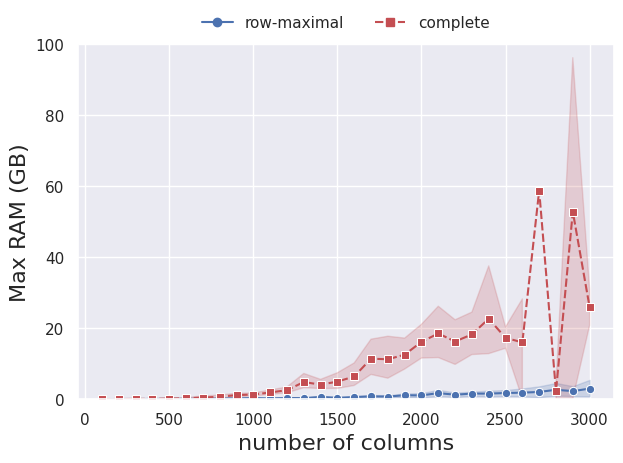

In [106]:
g_ram = sns.lineplot(
    data=data, 
    x="columns", y=feature, 
    hue="decomposition", 
    style="decomposition", 
    markers=MARKERS,
    palette=COLORS,
    )# hue_order=OBJ_FUNCTIONS)
# g_ram.text(x=0.5, y=1.1, s=f'{NAME} | Potential seeds of length 15 w.r.t. {chr(945)}', fontsize=FONTSIZE_TITLE, weight='bold', ha='center', va='bottom', transform=g_ram.transAxes)
# g_potential_seeds.text(x=0.5, y=1.05, s=f'Complete vs Row-maximal decomposition | not-{chr(945)}-consistent', fontsize=FONTSIZE_SUBTITLE, alpha=0.75, ha='center', va='bottom', transform=g_potential_seeds.transAxes)
g_ram.set_xlabel(f"number of columns", fontsize=FONTSIZE_X)
g_ram.set_ylabel("Max RAM (GB)", fontsize=FONTSIZE_Y)
g_ram.set_ylim([MIN_RAM,MAX_RAM])

sns.move_legend(
    g_ram, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

g_ram.figure.tight_layout()
g_ram.get_figure().savefig(PATH_SAVE.joinpath(f"{NAME}-ilp-instances-RAM.png"),dpi=300)

## User Time

In [107]:
feature = "User time (min)"
# min and max y-axis values
feat_min = data[feature].min()
feat_max = max(data[feature].max(), info_pggb[feature], info_vg[feature]) 
delta_range = feat_max - feat_min
ymin = feat_min - 0.01*delta_range 
ymax = feat_max + 0.01*delta_range

In [108]:
ymax

131.3

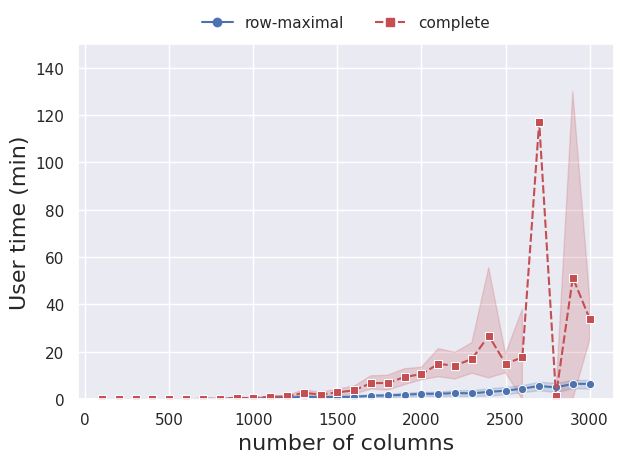

In [109]:
g_time = sns.lineplot(
    data=data,#.query("decomposition!='row-maximal'"), 
    x="columns", y=feature, 
    hue="decomposition", 
    style="decomposition", 
    markers=MARKERS,
    palette=COLORS,
    )
g_time.set_xlabel(f"number of columns", fontsize=FONTSIZE_X)
g_time.set_ylabel("User time (min)", fontsize=FONTSIZE_Y)
g_time.set_ylim([MIN_TIME,MAX_TIME])

sns.move_legend(
    g_time, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

g_time.figure.tight_layout()
g_time.get_figure().savefig(PATH_SAVE.joinpath(f"{NAME}-ilp-instances-User_time.png"),dpi=300)

___
Bivariate plot 

In [110]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [111]:
_y = "# variables"
_x = "# columns"

In [112]:
data_plot=data.copy() # .query("decomposition == 'row-maximal'").copy() # query("decomposition == 'row-maximal'")
data_plot[_x] = data_plot["columns"]
data_plot[_y] = data_plot["Number of C variables"] 
# data_plot["# variables"]  = data_plot["Number of C variables"]

bin_ram=[1,5,10,15,20,100]
bin_ram_label=[f"{x}" for x in bin_ram[:-1] ]
data_plot["RAM"] = pd.cut(data["Max RAM (GB)"], bin_ram, labels=bin_ram_label)

bin_time=[1,10,15,30,60,1800]
bin_time_label=[f"{x}" for x in bin_time[:-1] ]
data_plot["User time"] = pd.cut(data["User time (seconds)"], bin_time, labels=bin_time_label)


bin_var=[x for x in range(1000,400001, 1000)]
bin_var_label=[f"{x}" for x in bin_var[:-1] ]# "<10","<30","<60","<180","<600"]
data_plot["variables"] = pd.cut(data_plot["# variables"], bin_var, labels=bin_var_label)

In [113]:

# # Draw a combo histogram and scatterplot with density contours
# f, ax = plt.subplots(figsize=(6, 6))
# sns.scatterplot(
#     data_plot, 
#     x=x, y=y, s=20, color="1.2.", 
#     hue="User time",
#     style="decomposition", markers=["D", "o"],
#     palette="rocket_r"
#     )

/tmp/ipykernel_989276/3239514577.py:1: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  rp_time = sns.relplot(


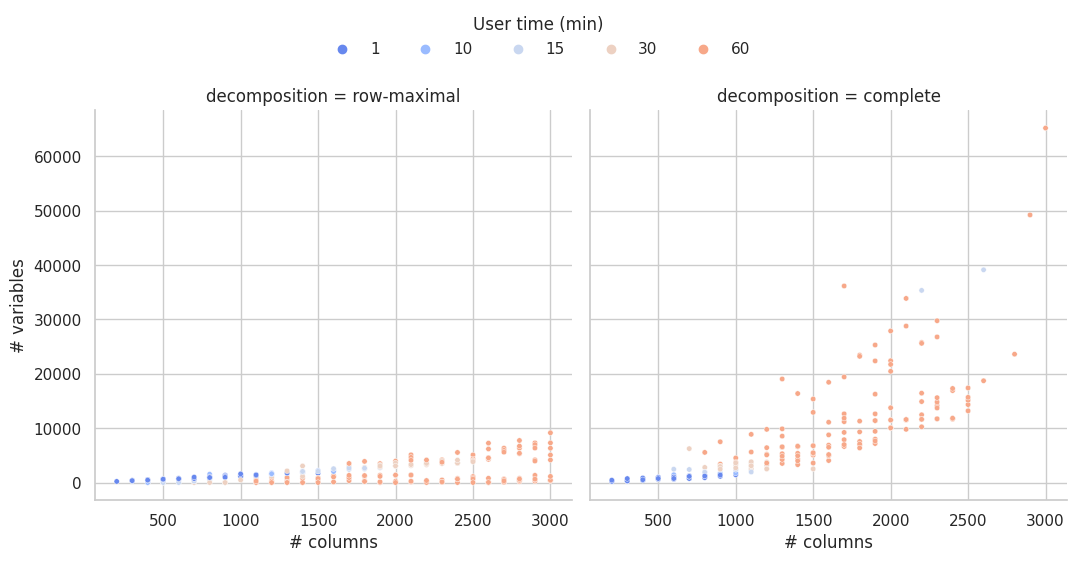

In [114]:
rp_time = sns.relplot(
    data_plot, 
    x=_x, y=_y, s=15, color="1.2.", 
    hue="User time",
    # palette=sns.diverging_palette(220, 20, center = "dark", as_cmap=False),
    # palette=sns.color_palette("Spectral", as_cmap=False),
    palette=sns.color_palette("coolwarm", as_cmap=False,),
    kind="scatter",
    col="decomposition",
    # alpha=0.3,
    )

# rp_time.set_xlabel(f"# columns", fontsize=FONTSIZE_X)
# rp_time.set_ylabel("# decision variables", fontsize=FONTSIZE_Y)

sns.move_legend(
    rp_time, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title="User time (min)", frameon=False,
)

rp_time.figure.tight_layout()
rp_time.savefig(PATH_SAVE.joinpath(f"{NAME}-user_time-scatter.png"),dpi=300)

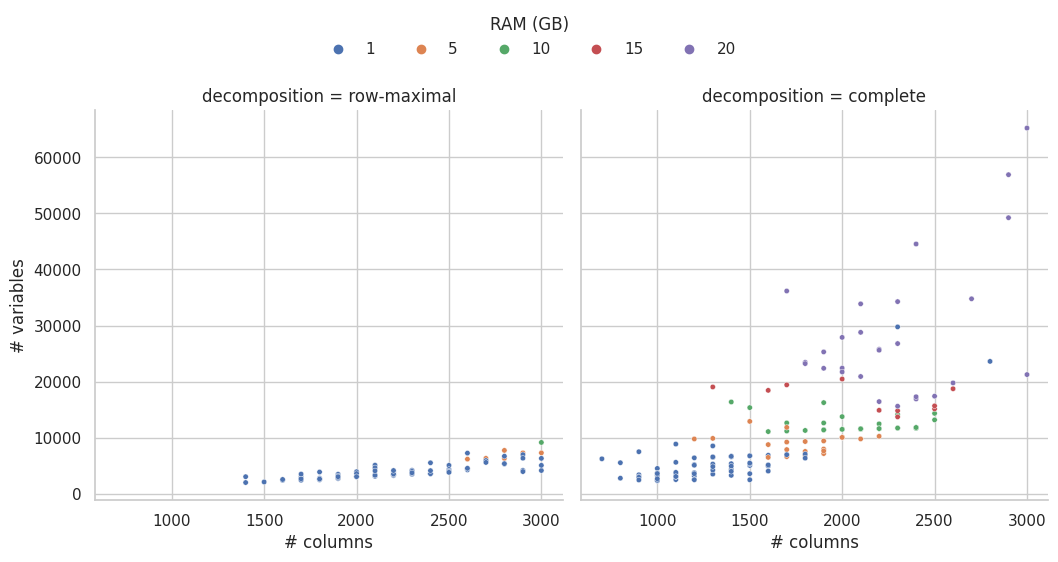

In [115]:
rp_ram = sns.relplot(
    data_plot, 
    x=_x, y=_y, s=15, color="1.2.", 
    hue="RAM",
    # palette=sns.light_palette("#79C"),
    kind="scatter",
    col="decomposition",
    )

sns.move_legend(
    rp_ram, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title="RAM (GB)", frameon=False,
)

rp_ram.figure.tight_layout()
rp_ram.savefig(PATH_SAVE.joinpath(f"{NAME}-ram-scatter.png"),dpi=300)